### 과제 요구 사항들을 구현하고, epoch마다의 train loss와 최종 모델의 test accuracy가 print된 notebook을 public github repository에 업로드하여 공유해주시면 됩니다. 반드시 출력 결과가 남아있어야 합니다. 

- [x] AG_News dataset 준비
	- Huggingface dataset의 `fancyzhx/ag_news`를 load
	- `collate_fn` 함수에 다음 수정사항들을 반영
    - Truncation과 관련된 부분들을 삭제
- [x] Classifier output, loss function, accuracy function 변경
	- 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제입니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropyLoss` 를 추가하고 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정
	- 그리고 정확도를 재는 `accuracy` 함수도 classification에 맞춰 수정
- [x]  학습 결과 report
    - DistilBERT 실습과 같이 매 epoch 마다의 train loss를 출력하고 최종 모델의 test accuracy를 report 첨부
  
- [x] 완료된 항목은 체크박스에 x 표시

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [95]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['CUDA_LAUNCH_BLOCKING']='1'




In [96]:
import torch
from torch import Tensor
from torch.optim import Adam
from datasets import load_dataset
from torch.utils.data import DataLoader
from typing import List, Tuple, Dict, Any, Union

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in C:\Users\junu/.cache\torch\hub\huggingface_pytorch-transformers_main


fancyzhx/ag_news
https://www.oxen.ai/fancyzhx/ag_news

In [97]:
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

print(train_ds)
print(train_ds[0])
print(train_ds.features["label"])

Dataset({
    features: ['text', 'label'],
    num_rows: 6000
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


In [98]:
names=['World', 'Sports', 'Business', 'Sci/Tech']

In [99]:


# Collate 함수 정의 (필요한 경우)
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    return {
        'text': texts,
        'label': torch.tensor(labels)
    }

# DataLoader 생성
train_loader = DataLoader(
    train_ds, 
    batch_size=64, 
    shuffle=True, 
    collate_fn=collate_fn
)

# 첫 번째 배치 가져오기
first_batch = next(iter(train_loader))
print("배치 데이터 구조:", first_batch.keys())
print("\n배치 크기:", len(first_batch['text']))

# 첫 번째 배치에서 첫 번째 샘플 출력
print("\n첫 번째 샘플:")
print("텍스트:", first_batch['text'][0])
print("레이블:", first_batch['label'][0].item())

# 첫 번째 배치에서 데이터셋의 원본 구조 확인 (추가 필드가 있는지)
print("\n원본 데이터셋 구조:")
for key in train_ds[0].keys():
    print(f"- {key}")

# 원본 데이터셋에서 하나의 row 직접 출력
print("\n원본 데이터셋의 첫 번째 row:")
print(train_ds[0])

배치 데이터 구조: dict_keys(['text', 'label'])

배치 크기: 64

첫 번째 샘플:
텍스트: Baghdad Blast Kills Seven, Najaf Fighting Rages  BAGHDAD (Reuters) - A shell killed seven people in a busy  Baghdad street on Tuesday and U.S. forces fought pitched  battles with Shi'ite militia in the holy city of Najaf.
레이블: 0

원본 데이터셋 구조:
- text
- label

원본 데이터셋의 첫 번째 row:
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


왜 패딩 처리하지 않는가

In [100]:
# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)


# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고 패딩 적용
    encoded_inputs = tokenizer(
        texts, 
        padding='longest',  # 배치 내 가장 긴 시퀀스에 맞춰 패딩
        max_length=512,     # 최대 길이를 512로 설정
        truncation=False,   # truncation은 끄되, 최대 길이를 지정해 안전하게 처리
        return_tensors='pt'  # PyTorch 텐서로 반환
    )
    
    # 토큰화된 입력과 라벨 반환
    return encoded_inputs.input_ids, torch.LongTensor(labels)

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [101]:
first_batch = next(iter(train_loader))
print(first_batch)

(tensor([[  101,  2762,  2559,  ...,     0,     0,     0],
        [  101,  2329,  5430,  ...,     0,     0,     0],
        [  101,  7726,  2097,  ...,     0,     0,     0],
        ...,
        [  101,  2825,  5964,  ...,     0,     0,     0],
        [  101, 16222,  2208,  ...,     0,     0,     0],
        [  101, 16012, 12589,  ...,     0,     0,     0]]), tensor([2, 3, 1, 2, 1, 1, 3, 2, 2, 2, 1, 2, 2, 3, 1, 2, 1, 2, 1, 2, 1, 3, 3, 1,
        1, 2, 3, 3, 1, 1, 2, 0, 0, 1, 2, 3, 2, 1, 2, 3, 1, 2, 0, 3, 0, 2, 3, 1,
        3, 1, 2, 1, 0, 3, 0, 1, 0, 0, 1, 1, 0, 1, 1, 3]))


In [102]:
first_batch = next(iter(train_loader))
print(first_batch)

(tensor([[  101,  8224, 13109,  ...,     0,     0,     0],
        [  101,  8040,  3270,  ...,     0,     0,     0],
        [  101, 15768,  2039,  ...,     0,     0,     0],
        ...,
        [  101,  2599, 23125,  ...,     0,     0,     0],
        [  101, 11909,  4915,  ...,     0,     0,     0],
        [  101, 14086,  1005,  ...,     0,     0,     0]]), tensor([2, 1, 2, 2, 3, 2, 0, 3, 0, 3, 1, 0, 1, 1, 0, 3, 1, 3, 0, 1, 3, 3, 2, 2,
        3, 3, 1, 1, 3, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 0, 3, 2, 1, 3, 3,
        2, 2, 1, 2, 0, 3, 1, 3, 0, 3, 2, 0, 1, 3, 3, 2]))


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [103]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in C:\Users\junu/.cache\torch\hub\huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [104]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')

        # [CLS] 토큰 분류기 정의 - 4개 
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력 (4개 클래스에 대한 logit)

model = TextClassifier()

Using cache found in C:\Users\junu/.cache\torch\hub\huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [105]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [106]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

encoder.embeddings.word_embeddings.weight: False
encoder.embeddings.position_embeddings.weight: False
encoder.embeddings.LayerNorm.weight: False
encoder.embeddings.LayerNorm.bias: False
encoder.transformer.layer.0.attention.q_lin.weight: False
encoder.transformer.layer.0.attention.q_lin.bias: False
encoder.transformer.layer.0.attention.k_lin.weight: False
encoder.transformer.layer.0.attention.k_lin.bias: False
encoder.transformer.layer.0.attention.v_lin.weight: False
encoder.transformer.layer.0.attention.v_lin.bias: False
encoder.transformer.layer.0.attention.out_lin.weight: False
encoder.transformer.layer.0.attention.out_lin.bias: False
encoder.transformer.layer.0.sa_layer_norm.weight: False
encoder.transformer.layer.0.sa_layer_norm.bias: False
encoder.transformer.layer.0.ffn.lin1.weight: False
encoder.transformer.layer.0.ffn.lin1.bias: False
encoder.transformer.layer.0.ffn.lin2.weight: False
encoder.transformer.layer.0.ffn.lin2.bias: False
encoder.transformer.layer.0.output_layer_nor

In [107]:
# 인코더 파라미터 확인
encoder_params = sum(p.numel() for p in model.encoder.parameters())
encoder_trainable = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print(f"인코더 파라미터: {encoder_params}, 학습 가능: {encoder_trainable}")

# 분류기 파라미터 확인
classifier_params = sum(p.numel() for p in model.classifier.parameters())
classifier_trainable = sum(p.numel() for p in model.classifier.parameters() if p.requires_grad)
print(f"분류기 파라미터: {classifier_params}, 학습 가능: {classifier_trainable}")

인코더 파라미터: 66362880, 학습 가능: 0
분류기 파라미터: 3076, 학습 가능: 3076


위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [108]:
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적
    
    # 모델의 파라미터에서 디바이스 확인
    device = next(model.parameters()).device
    
    for data in dataloader:
        inputs, labels = data
        # 파라미터에서 얻은 디바이스로 데이터 이동
        inputs, labels = inputs.to(device), labels.to(device)

        logits = model(inputs)  # 로짓(logit) 출력
        preds = torch.argmax(logits, dim=1)  # 가장 높은 점수의 클래스 선택

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

In [109]:


# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # 다중 분류용 손실 함수로 변경

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 5

train_result = []
test_result = []

# 학습 루프
for epoch in range(n_epochs):
    model.train()  # 학습 모드 설정
    total_loss = 0.
    batch_count = 0
    
    for data in train_loader:
        optimizer.zero_grad()  # 이전 gradient 초기화 (model.zero_grad() 대신)
        
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        
        # 손실 값 확인 (디버깅용)
        if batch_count == 0:
            print(f"첫 번째 배치 손실 값: {loss.item()}")
            
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
    
    # 배치 수로 나누어 평균 손실 계산
    avg_loss = total_loss / batch_count
    print(f"Epoch {epoch:3d} | 평균 손실: {avg_loss:.4f} | 총 손실: {total_loss:.4f}")
    
    # 학습 중간에 정확도 평가
    with torch.no_grad():
        model.eval()  # 평가 모드로 전환
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        print(f"Epoch {epoch:3d} | 학습 정확도: {train_acc:.3f} | 테스트 정확도: {test_acc:.3f}")
        model.train()  # 다시 학습 모드로 전환
        
        # 결과 저장
        train_result.append(train_acc)
        test_result.append(test_acc)
# ... existing code ...

첫 번째 배치 손실 값: 1.3801814317703247
Epoch   0 | 평균 손실: 1.0582 | 총 손실: 99.4689
Epoch   0 | 학습 정확도: 0.804 | 테스트 정확도: 0.818
첫 번째 배치 손실 값: 0.947978138923645
Epoch   1 | 평균 손실: 0.7435 | 총 손실: 69.8909
Epoch   1 | 학습 정확도: 0.832 | 테스트 정확도: 0.837
첫 번째 배치 손실 값: 0.5723423361778259
Epoch   2 | 평균 손실: 0.6262 | 총 손실: 58.8582
Epoch   2 | 학습 정확도: 0.838 | 테스트 정확도: 0.834
첫 번째 배치 손실 값: 0.625190794467926
Epoch   3 | 평균 손실: 0.5742 | 총 손실: 53.9719
Epoch   3 | 학습 정확도: 0.838 | 테스트 정확도: 0.829
첫 번째 배치 손실 값: 0.602677047252655
Epoch   4 | 평균 손실: 0.5479 | 총 손실: 51.4997
Epoch   4 | 학습 정확도: 0.839 | 테스트 정확도: 0.837


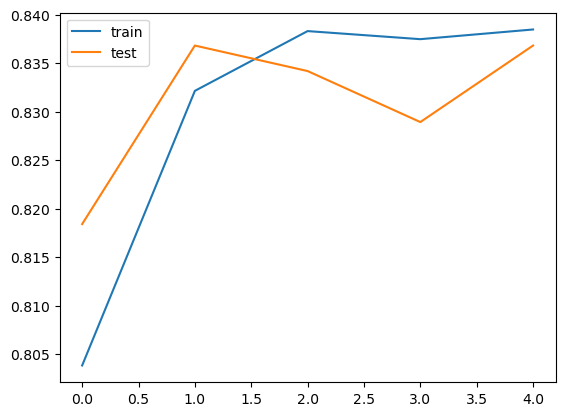

In [110]:
import sys
# 또는 상대 경로
sys.path.append('..') 

from util.plot import plot_acc


plot_acc(train_result, test_result)